<a href="https://colab.research.google.com/github/shubhamkoul007/Acquire-Valued-Shopper-Challenge-Team1-TDL/blob/main/CLV_Modelling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING MODULES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



**IMPORTING DATASET**

In [3]:
df = pd.read_csv('online_retail_II.csv' )

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


**CHECKING DATA DISCREPANCY**

In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
df.rename( columns ={'Customer ID': 'CustomerID' , 'Price' : 'UnitPrice'} , inplace= True  )

**DATA CLEANING (REMOVING DISCREPANCY)**

In [7]:
#Removing all customer id's with Null Value
df=df[pd.notnull(df['CustomerID'])]

#Removing all the returned items(Quantity less than equal to 0)
df=df[df['Quantity']>0]
df['Sales'] = df['Quantity'] * df['UnitPrice']
df[df['CustomerID']==12347]['Sales'].sum()#this monetary value does not match with the monetary value that we get after summary_from_transaction_data


5633.320000000001

In [8]:
df['CustomerID'].nunique()

5881

**LIFETIMES PACKAGE**

It is basically a library in python that is mainly used to predict future purchases of a customer, his alive probability and Customer's Lifetime Value , that can be used to draw useful insights .

**Installing Lifetimes Package**

In [9]:
!pip install lifetimes

     |████████████████████████████████| 593kB 4.8MB/s 


In [10]:
from lifetimes.plotting import *
from lifetimes.utils import *
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-10')

data.head()


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,7.0,400.0,726.0,11066.637143
12347.0,7.0,402.0,405.0,717.398571
12348.0,4.0,363.0,439.0,449.310000
12349.0,3.0,571.0,590.0,1120.056667
12350.0,0.0,0.0,311.0,0.000000


In [11]:
import time
start=time.time()
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
#print(bgf)

end =time.time()
print("TIme elapsed :",end-start,"seconds")


TIme elapsed : 0.2767007350921631 seconds


In [12]:
import time
start=time.time()
from lifetimes import ParetoNBDFitter
pareto = ParetoNBDFitter(penalizer_coef=0.0)
pareto.fit(data['frequency'], data['recency'], data['T'])
#print(bgf)

end =time.time()
print("TIme elapsed :",end-start,"seconds")



TIme elapsed : 4.168360471725464 seconds


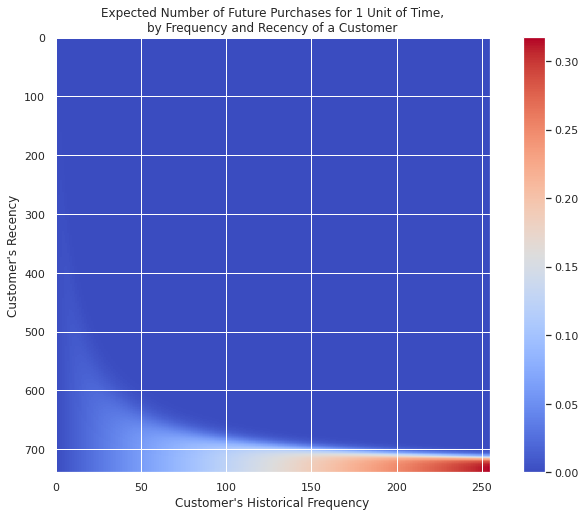

In [13]:

import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap':'coolwarm'})
%matplotlib inline
from lifetimes.plotting import plot_frequency_recency_matrix

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)


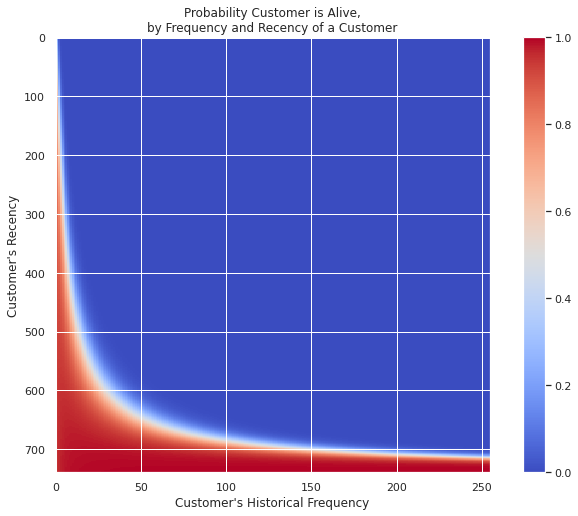

In [14]:
from lifetimes.plotting import plot_probability_alive_matrix
fig =plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)


In [15]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary)) 


            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           7.0    400.0  726.0    11066.637143
12347.0           7.0    402.0  405.0      717.398571
12348.0           4.0    363.0  439.0      449.310000
12349.0           3.0    571.0  590.0     1120.056667
12352.0           8.0    356.0  393.0      338.261250
4189


In [16]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)


<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 2.13, q: 3.53, v: 486.53>


In [17]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 

print(ggf.conditional_expected_average_profit(
        returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value']
    ).head(10))



CustomerID
12346.0    9520.529482
12347.0     672.740683
12348.0     440.212758
12349.0     918.531323
12352.0     347.481829
12353.0     263.054511
12355.0     432.350492
12356.0     961.519741
12357.0    3059.669630
12358.0     567.432251
dtype: float64


In [18]:

#Calculate Customer Lifetime Value
returning_customers_summary['CLV'] = round(ggf.customer_lifetime_value(
    bgf, returning_customers_summary['frequency'],returning_customers_summary['recency'],
    returning_customers_summary['T'], returning_customers_summary['monetary_value'],
    time=12, discount_rate=0.01 ), 2)

returning_customers_summary.head()


,frequency,recency,T,monetary_value,CLV
CustomerID,,,,,
12346.0,7.0,400.0,726.0,11066.637143,17255.85
12347.0,7.0,402.0,405.0,717.398571,3554.63
12348.0,4.0,363.0,439.0,449.310000,1285.67
12349.0,3.0,571.0,590.0,1120.056667,1655.55
12352.0,8.0,356.0,393.0,338.261250,2106.28


In [19]:
Unique_Customers = len( returning_customers_summary )
Unique_Customers


4189

In [20]:
returning_customers_summary = returning_customers_summary.reindex(columns= ['CustomerID','frequency','recency','T','monetary_value','CLV'])

returning_customers_summary['CustomerID'] = returning_customers_summary.index

returning_customers_summary.reset_index(drop=True, inplace=True)

returning_customers_summary.head(10)



,CustomerID,frequency,recency,T,monetary_value,CLV
0,12346.0,7.0,400.0,726.0,11066.637143,17255.85
1,12347.0,7.0,402.0,405.0,717.398571,3554.63
2,12348.0,4.0,363.0,439.0,449.310000,1285.67
3,12349.0,3.0,571.0,590.0,1120.056667,1655.55
4,12352.0,8.0,356.0,393.0,338.261250,2106.28
5,12353.0,1.0,204.0,409.0,89.000000,272.85
6,12355.0,1.0,353.0,568.0,459.400000,345.54
7,12356.0,5.0,402.0,425.0,1092.648000,3576.11
8,12357.0,1.0,355.0,389.0,6207.670000,3515.43
9,12358.0,4.0,730.0,732.0,614.310000,1080.24


In [21]:
sorted_returning_customers_summary = returning_customers_summary.sort_values(by='CLV', ascending=False )

sorted_returning_customers_summary['rank'] = [ i for i in range(1,Unique_Customers+1)  ]

sorted_returning_customers_summary.reset_index(drop=True, inplace=True)

sorted_returning_customers_summary


,CustomerID,frequency,recency,T,monetary_value,CLV,rank
0,18102.0,66.0,738.0,739.0,9189.930455,247768.22,1
1,14646.0,90.0,736.0,738.0,5809.905333,214375.44,2
2,16446.0,1.0,205.0,206.0,168469.600000,147748.15,3
3,17450.0,30.0,430.0,439.0,6924.523000,132600.94,4
4,14156.0,120.0,729.0,739.0,2607.329750,128042.86,5
...,...,...,...,...,...,...,...
4184,15633.0,12.0,222.0,732.0,346.714167,0.52,4185
4185,14590.0,18.0,308.0,733.0,161.012222,0.16,4186
4186,13093.0,42.0,460.0,736.0,1284.528095,0.12,4187
4187,17448.0,17.0,148.0,646.0,830.904706,0.00,4188


In [22]:
recency=(sorted_returning_customers_summary['recency'].to_numpy())
freq=sorted_returning_customers_summary['frequency'].to_numpy()


rf =zip(recency,freq)
lst=[]

for r,f in rf:
    lst.append(bgf.conditional_probability_alive_matrix(int(sorted_returning_customers_summary['frequency'].max()),int(sorted_returning_customers_summary['recency'].max()))[int(r),int(f)])
print(lst)


[0.9983717094170447, 0.998493588175918, 0.7818840387976242, 9.91672190598317e-05, 0.99647378621301, 0.99940861602646, 3.604295911635626e-10, 0.9975525409496768, 0.07555171144795253, 0.9974208389156741, 0.9952260578009176, 0.9979328854919178, 0.9986411053754257, 0.9981664061921616, 0.9994404419268609, 0.9162429133183604, 0.9921995200796812, 0.9933668721532338, 0.9936732167026625, 0.09218507655061743, 0.997032424598718, 0.990816179060196, 0.9990806882140153, 0.4313973174811353, 1.1117040156503313e-06, 0.9988452184717316, 0.995917622735774, 0.9924838689357484, 0.9872053561637691, 0.997498493109653, 0.005818822724999722, 0.9979032250598242, 0.997498694150175, 0.9848026271736197, 0.8383919709771085, 0.5353457334997168, 0.09147599550287745, 2.861856130905478e-07, 0.9914527089771881, 0.9946459817179475, 0.996350148974461, 0.9961934676069543, 0.9957022613100517, 0.320987855768999, 0.9962365826318359, 0.9937938152874172, 0.9961932803721755, 0.9978619323840553, 0.9965751818209047, 0.003569704033

In [23]:
sorted_returning_customers_summary['Alive Probability'] = lst 

sorted_returning_customers_summary.head()


,CustomerID,frequency,recency,T,monetary_value,CLV,rank,Alive Probability
0,18102.0,66.0,738.0,739.0,9189.930455,247768.22,1,0.998372
1,14646.0,90.0,736.0,738.0,5809.905333,214375.44,2,0.998494
2,16446.0,1.0,205.0,206.0,168469.600000,147748.15,3,0.781884
3,17450.0,30.0,430.0,439.0,6924.523000,132600.94,4,0.000099
4,14156.0,120.0,729.0,739.0,2607.329750,128042.86,5,0.996474


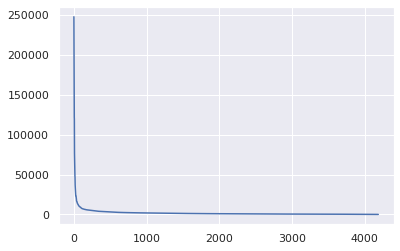

In [24]:
plt.plot( sorted_returning_customers_summary['rank'] , sorted_returning_customers_summary['CLV'] ) 

plt.show()


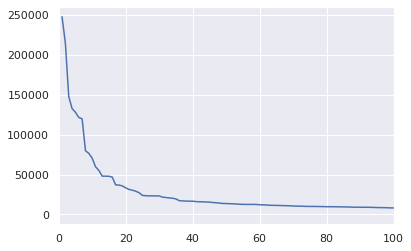

In [25]:
plt.plot( sorted_returning_customers_summary['rank'] , sorted_returning_customers_summary['CLV'] ) 

plt.xlim(0,100)

plt.show()

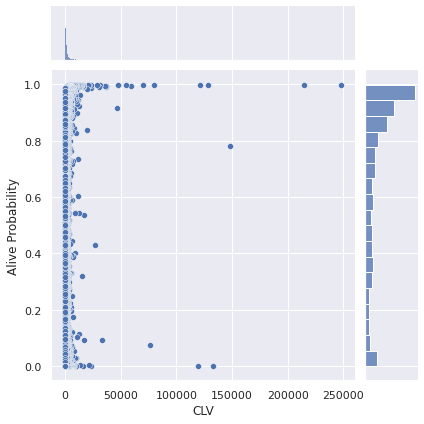

In [26]:
sns.jointplot( x = 'CLV' , y = 'Alive Probability' , data = sorted_returning_customers_summary )

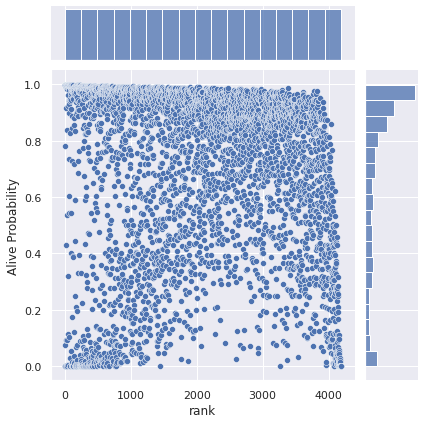

In [28]:
sns.jointplot( x = 'rank' , y = 'Alive Probability' , data = sorted_returning_customers_summary )

In [29]:
sorted_returning_customers_summary


,CustomerID,frequency,recency,T,monetary_value,CLV,rank,Alive Probability
0,18102.0,66.0,738.0,739.0,9189.930455,247768.22,1,9.983717e-01
1,14646.0,90.0,736.0,738.0,5809.905333,214375.44,2,9.984936e-01
2,16446.0,1.0,205.0,206.0,168469.600000,147748.15,3,7.818840e-01
3,17450.0,30.0,430.0,439.0,6924.523000,132600.94,4,9.916722e-05
4,14156.0,120.0,729.0,739.0,2607.329750,128042.86,5,9.964738e-01
...,...,...,...,...,...,...,...,...
4184,15633.0,12.0,222.0,732.0,346.714167,0.52,4185,2.559442e-04
4185,14590.0,18.0,308.0,733.0,161.012222,0.16,4186,1.030514e-04
4186,13093.0,42.0,460.0,736.0,1284.528095,0.12,4187,5.041853e-06
4187,17448.0,17.0,148.0,646.0,830.904706,0.00,4188,1.001522e-08


In [30]:
sorted_returning_customers_summary.to_csv("Customer_Lifetime_Value_Insights.csv")

In [31]:
sorted_returning_customers_summary.to_excel('Customer_Lifetime_Value_Insights.xlsx')